# Inspiral Amplitude Model

This notebook creates the inspiral amplitude model.

## Steps

0. Configs
    - output dir
    - ansatz
    - fit parameters
1. loads NR data and defines train/test split
2. Fit ansatz to each sample
3. Parameter space fit
4. model validation
5. save model (GPs)

# Imports

In [143]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [144]:
import gpm_utils

In [145]:
import numpy as np
import os
import copy
import datetime
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# i tried joblib and dill to save the model but they didn't work
# because under the hood i used a sympy lambdify function
# this SO post solved my issue using cloudpickle.
# https://stackoverflow.com/a/31365136/12840171
import cloudpickle

In [146]:
# custom
import phenom
import workflow_utils
import pn

import collocation

In [147]:
import sympy
# sympy.init_printing()
# x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

# x_sym: generic name I use for independent variables for sympy
x_sym = sympy.symbols('x_sym')

# Config

In [148]:
target = 'amp'
region = 'inspiral'

tag = datetime.date.today().strftime("%d_%m_%y")

ROOT_DIR = "/Users/sebastian.khan/personal/data/gpm_model"
OUTPUT_DIR = f"{target}_{region}_{tag}"
OUTPUT_PATH = os.path.join(ROOT_DIR, OUTPUT_DIR)

print(f"{OUTPUT_DIR = }")
print(f"{OUTPUT_PATH = }")

OUTPUT_DIR = 'amp_inspiral_11_09_23'
OUTPUT_PATH = '/Users/sebastian.khan/personal/data/gpm_model/amp_inspiral_11_09_23'


In [149]:
os.makedirs(OUTPUT_PATH, exist_ok=False)

In [150]:
# TaylorT3 PN parameters
M=1

# Time range avaiable to use for fitting and testing
pad = 10
t_start = -700 - pad
# t_end = -300 + pad
t_end = -100 + pad

# can choose to resample or not
# dt = 0.1
dt = None

## DEFINE ANSATZ

# base_ansatz = np.sum([x_sym**(8./2)])
base_ansatz = np.sum([x_sym**(8./2), x_sym**(9./2)])
# base_ansatz = np.sum([x_sym**(8./2), x_sym**(9./2), x_sym**(10./2)])
# base_ansatz = np.sum([x_sym**(1.), x_sym**(2.), x_sym**(3)])
# base_ansatz = np.sum([x_sym**(8/2), x_sym**9, x_sym**10])
collocation_points = {
    # 0:[-700, -500, -300],
    # 0:[-700, -300],
    0:[-700, -100],
    # 0:[-300],
    # 0:[-700, -500, -200],
    # 0:[-700, -500, -300, -200],
    # 1:[-300],
}

# Load Inspiral Freq Model

In [151]:
# gpm_omega_inspiral = gpm_utils.GPM_Omega_Inspiral(model_components_filename='/Users/sebastian.khan/personal/data/gpm_model/freq_inspiral_26_02_23/components.cpkl')
# gpm_omega_inspiral = gpm_utils.GPM_Omega_Inspiral(model_components_filename='/Users/sebastian.khan/personal/data/gpm_model/freq_inspiral_07_09_23/components.cpkl')


# gpm_omega_inspiral = gpm_utils.GPM_Omega_Inspiral(model_components_filename='/Users/sebastian.khan/personal/data/gpm_model/freq_inspiral_08_09_23/components.cpkl')
gpm_omega_inspiral = gpm_utils.GPM_Omega_Inspiral(model_components_filename='/Users/sebastian.khan/personal/data/gpm_model/freq_inspiral_11_09_23/components.cpkl')

# Load NR

In [152]:
data_dict = workflow_utils.load_nr_data()

# test_set_query='(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16)'
# data_dict = workflow_utils.load_nr_data(test_set_query=test_set_query)



In [153]:
data_dict['train_idxs']

Int64Index([ 0,  4,  6,  8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26,
            27, 31, 35, 37, 38, 46, 51, 53],
           dtype='int64')

In [154]:
data_dict['test_idxs']

Int64Index([ 1,  2,  3,  5,  7,  9, 11, 14, 24, 25, 28, 29, 30, 32, 33, 34, 36,
            39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52],
           dtype='int64')

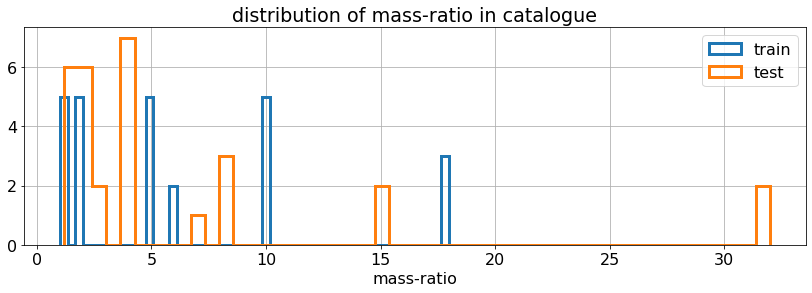

In [155]:
plt.figure(figsize=(14, 4))
plt.hist(data_dict['df']['q'][data_dict['train_idxs']], bins=50, histtype='step', lw=3, label='train')
plt.hist(data_dict['df']['q'][data_dict['test_idxs']], bins=50, histtype='step', lw=3, label='test')
plt.legend()
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

In [156]:
waveforms = [
    workflow_utils.Waveform(
        strain=data_dict['strains'][i],
        times=data_dict['times'],
        amp=data_dict['amps'][i],
        phase=data_dict['phases'][i],
        freq=data_dict['freqs'][i],
        q=data_dict['df']['q'].values[i],
        meta_data=data_dict['df'].loc[[i]],
    )
    for i in range(len(data_dict['df']))]

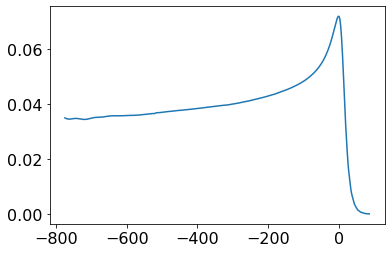

In [157]:
plt.plot(waveforms[0].times, waveforms[0].amp)

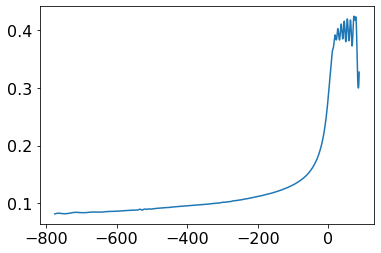

In [158]:
plt.plot(waveforms[0].times, waveforms[0].freq)

# Fit ansatz

In [159]:
workflow_utils.transform_collocation_t_to_x(collocation_points, 1, gpm_omega_inspiral)

{0: [0.09685753, 0.15264752]}

In [160]:

# wcfs: Waveform Collocation Fitter objects
wcfs = []
# list of TaylorT3 Newtonian term for each sample
amp_Ns = []
# list of TaylorT3 full PN for each sample
amp_pns = []


for i in range(len(data_dict['df'])):
    q = data_dict['df'].iloc[i]['q']
    name = data_dict['df'].iloc[i]['name']
    tag = data_dict['df'].iloc[i]['tag']
    set_member = data_dict['df'].iloc[i]['set']
    print(f"working: {i} ({set_member}): q={q} \t {name}")
    
    eta = phenom.eta_from_q(q)
    
    # get data to fit
    t_, y_ = workflow_utils.prepare_fit_data(
        waveform=waveforms[i],
        t_start=t_start,
        t_end=t_end,
        target=target,
        dt=dt,
    )
    
    # PN parameters
    # pn_kwargs=dict(t=t_, tc=tc, eta=eta, M=M)

    # Get PN transformation variables
    omega_22 = gpm_omega_inspiral.predict(t_, q, n_samples=-1)[0]
    x_ = pn.x_from_omega_22(omega_22, M=M)

    amp_N, amp_pn = workflow_utils.get_taylort3_inspiral_amp_affine_params(omega_22, eta, M)
        
    # apply tranformation
    y_transformed = workflow_utils.transformation_affine_reverse(y_, amp_N, amp_pn)
    
    # prepare ansatz
    ansatz = base_ansatz.copy()
    sub_dict={}
    
    collocation_points_x = workflow_utils.transform_collocation_t_to_x(collocation_points=collocation_points, q=q, gpm_omega_inspiral=gpm_omega_inspiral)
    
    wcf = workflow_utils.WaveformCollocationFitter(
        x_,
        y_transformed,
        collocation_points_x,
        ansatz,
        sub_dict,
    )
    
    
    # plt.figure()
    # plt.plot(t_, y_transformed)
    # plt.plot(t_, wcf.cm.predict(x_))
    # plt.title(tag)
    # plt.show()
    # plt.close()


    amp_Ns.append(amp_N)
    amp_pns.append(amp_pn)
    wcfs.append(wcf)

working: 0 (train): q=18.0 	 q18a0a0c025_96_fine
working: 1 (test): q=4.0 	 q4a0_T_96_384
working: 2 (test): q=8.0 	 q8a0a0_T_96_504n512
working: 3 (test): q=8.0 	 q8a0a0c05_T_80_420
working: 4 (train): q=10.0 	 q10c25e_T_112_448
working: 5 (test): q=4.0 	 q4a0_T_80_320
working: 6 (train): q=18.0 	 q18a0a0c025_144
working: 7 (test): q=8.0 	 q8a0a0_T_112_588n768
working: 8 (train): q=18.0 	 q18a0a0c025_120
working: 9 (test): q=4.0 	 q4a0_T_112_448
working: 10 (train): q=5.0 	 SXS_BBH_0107_Res3
working: 11 (test): q=4.0 	 SXS_BBH_0167_Res5
working: 12 (train): q=5.0 	 SXS_BBH_0107_Res5
working: 13 (train): q=5.0 	 SXS_BBH_0107_Res4
working: 14 (test): q=4.0 	 SXS_BBH_0167_Res3
working: 15 (train): q=2.0 	 SXS_BBH_0169_Res4
working: 16 (train): q=2.0 	 SXS_BBH_0169_Res5
working: 17 (train): q=2.0 	 SXS_BBH_0169_Res3
working: 18 (train): q=1.0 	 SXS_BBH_0180_Res3
working: 19 (train): q=10.0 	 SXS_BBH_0303_Res3
working: 20 (train): q=1.0 	 SXS_BBH_0180_Res2
working: 21 (train): q=10.0 	 SXS

In [161]:
titles_ = []
y0s_ = []
y1s_ = []
pns_ = []
for i in range(len(data_dict['df'])):
    title_ = data_dict['df']['tag'][i]
    y0_ = workflow_utils.transformation_affine_foward(wcfs[i].y, amp_Ns[i], amp_pns[i])
    y1_ = workflow_utils.transformation_affine_foward(wcfs[i].cm.predict(wcfs[i].x), amp_Ns[i], amp_pns[i])
    pn_ = amp_pns[i]
    
    titles_.append(title_)
    y0s_.append(y0_)
    y1s_.append(y1_)
    pns_.append(pn_)

y0s_ = np.array(y0s_)
y1s_ = np.array(y1s_)
pns_ = np.array(pns_)

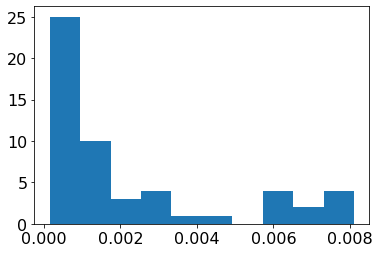

In [162]:
plt.hist(np.max(np.abs(y0s_ - y1s_), 1));

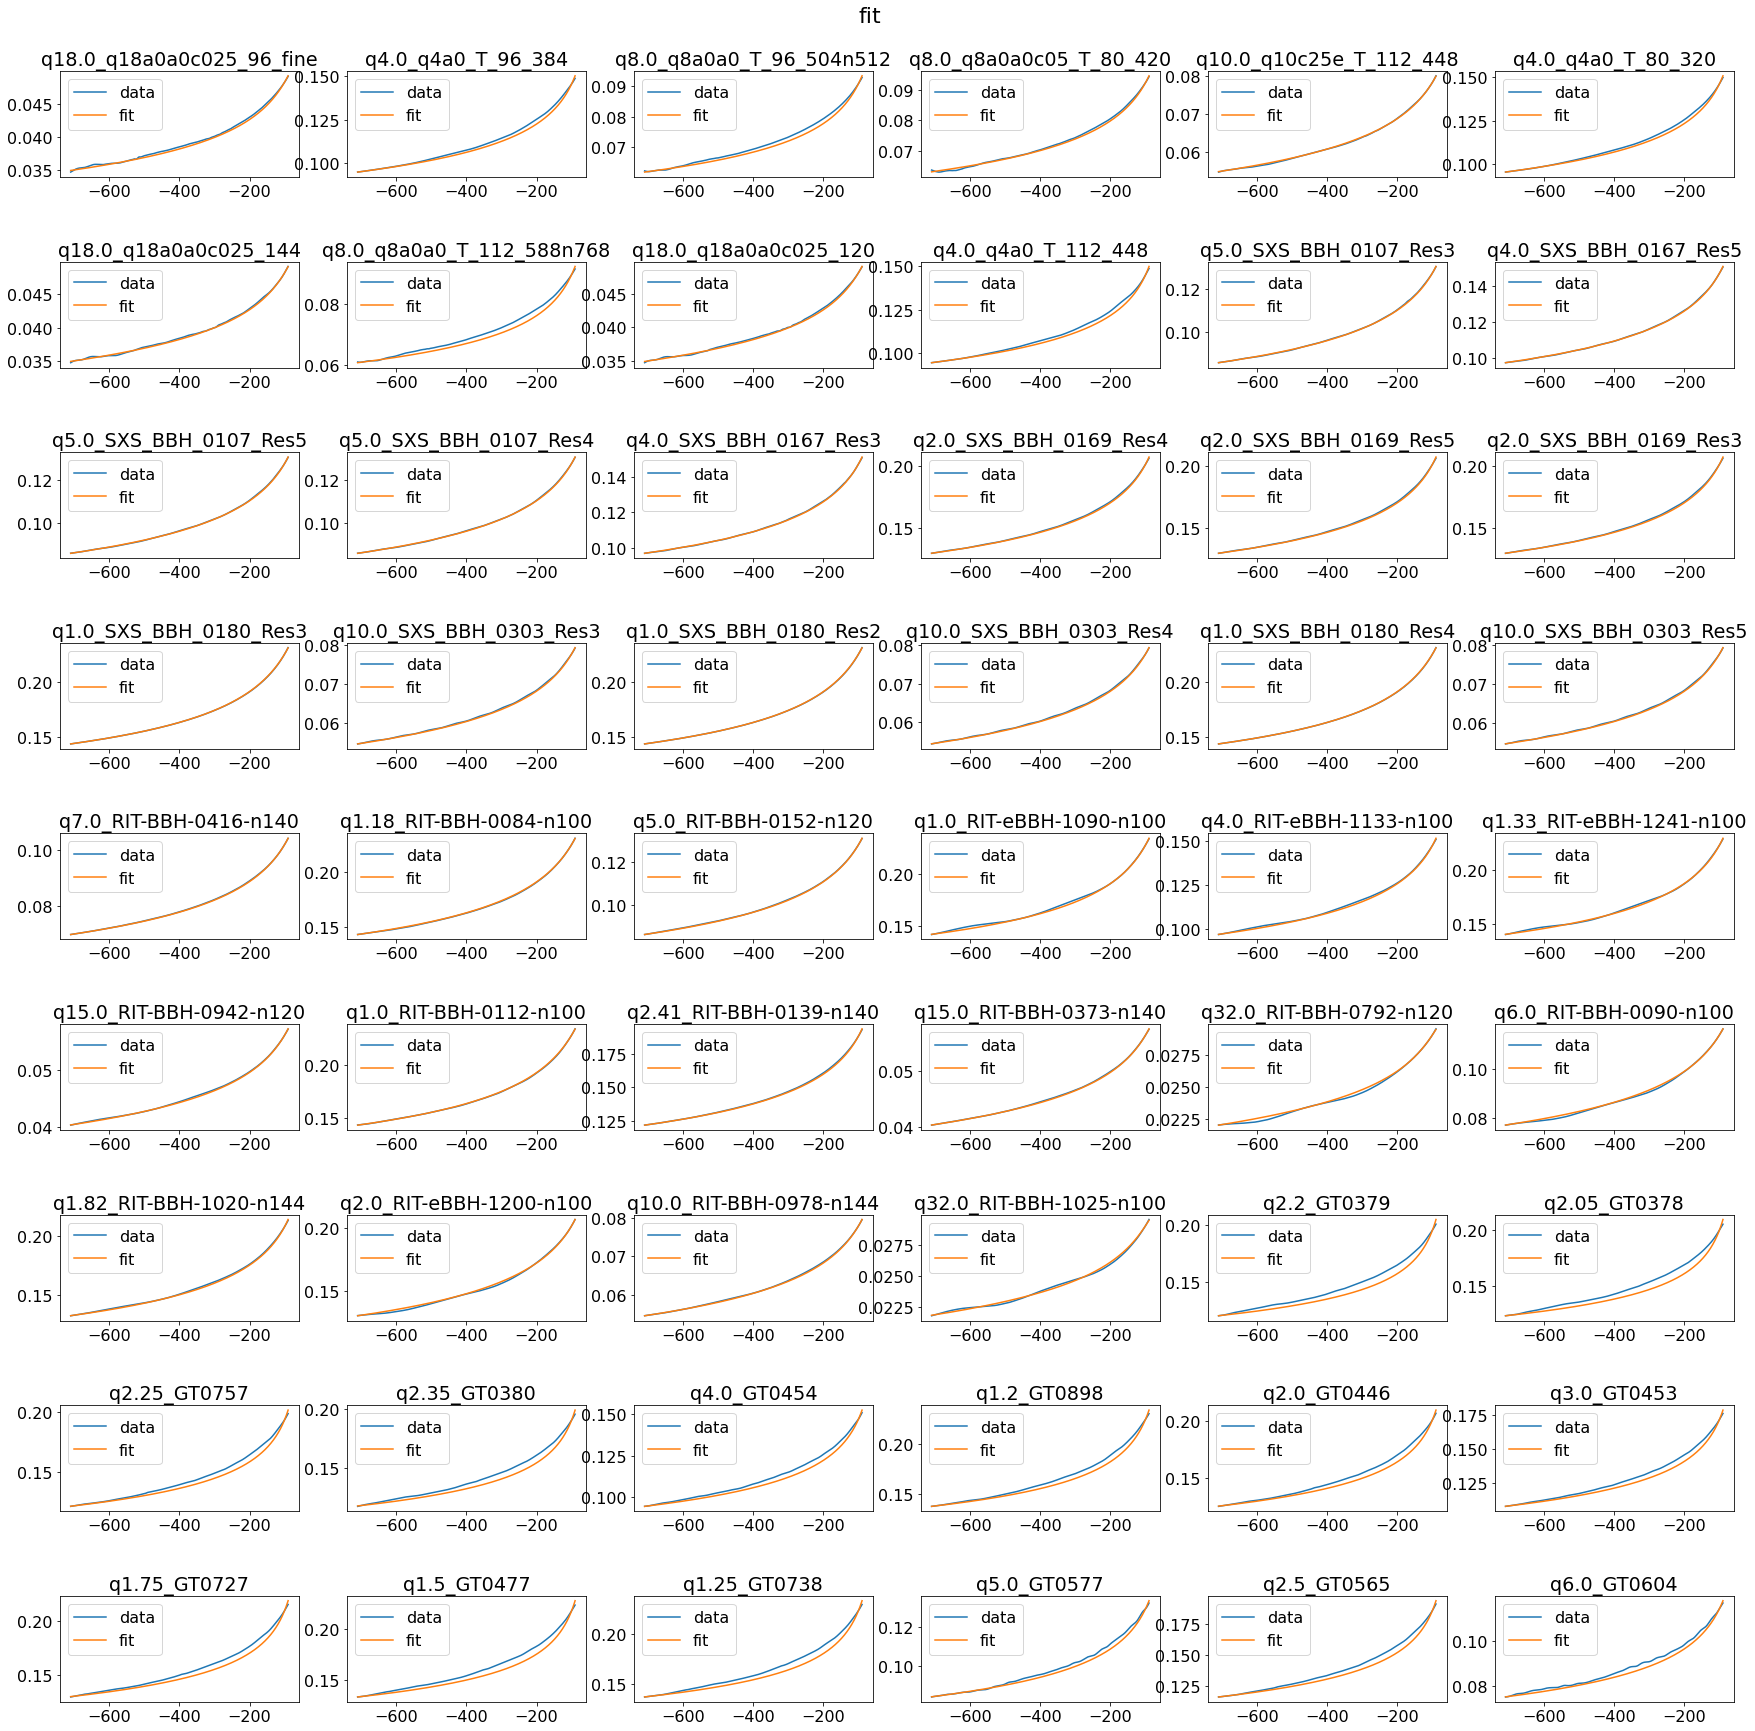

In [163]:
workflow_utils.plot_grid(xs=t_, ys=np.array([y0s_, y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data','fit'], suptitle="fit")

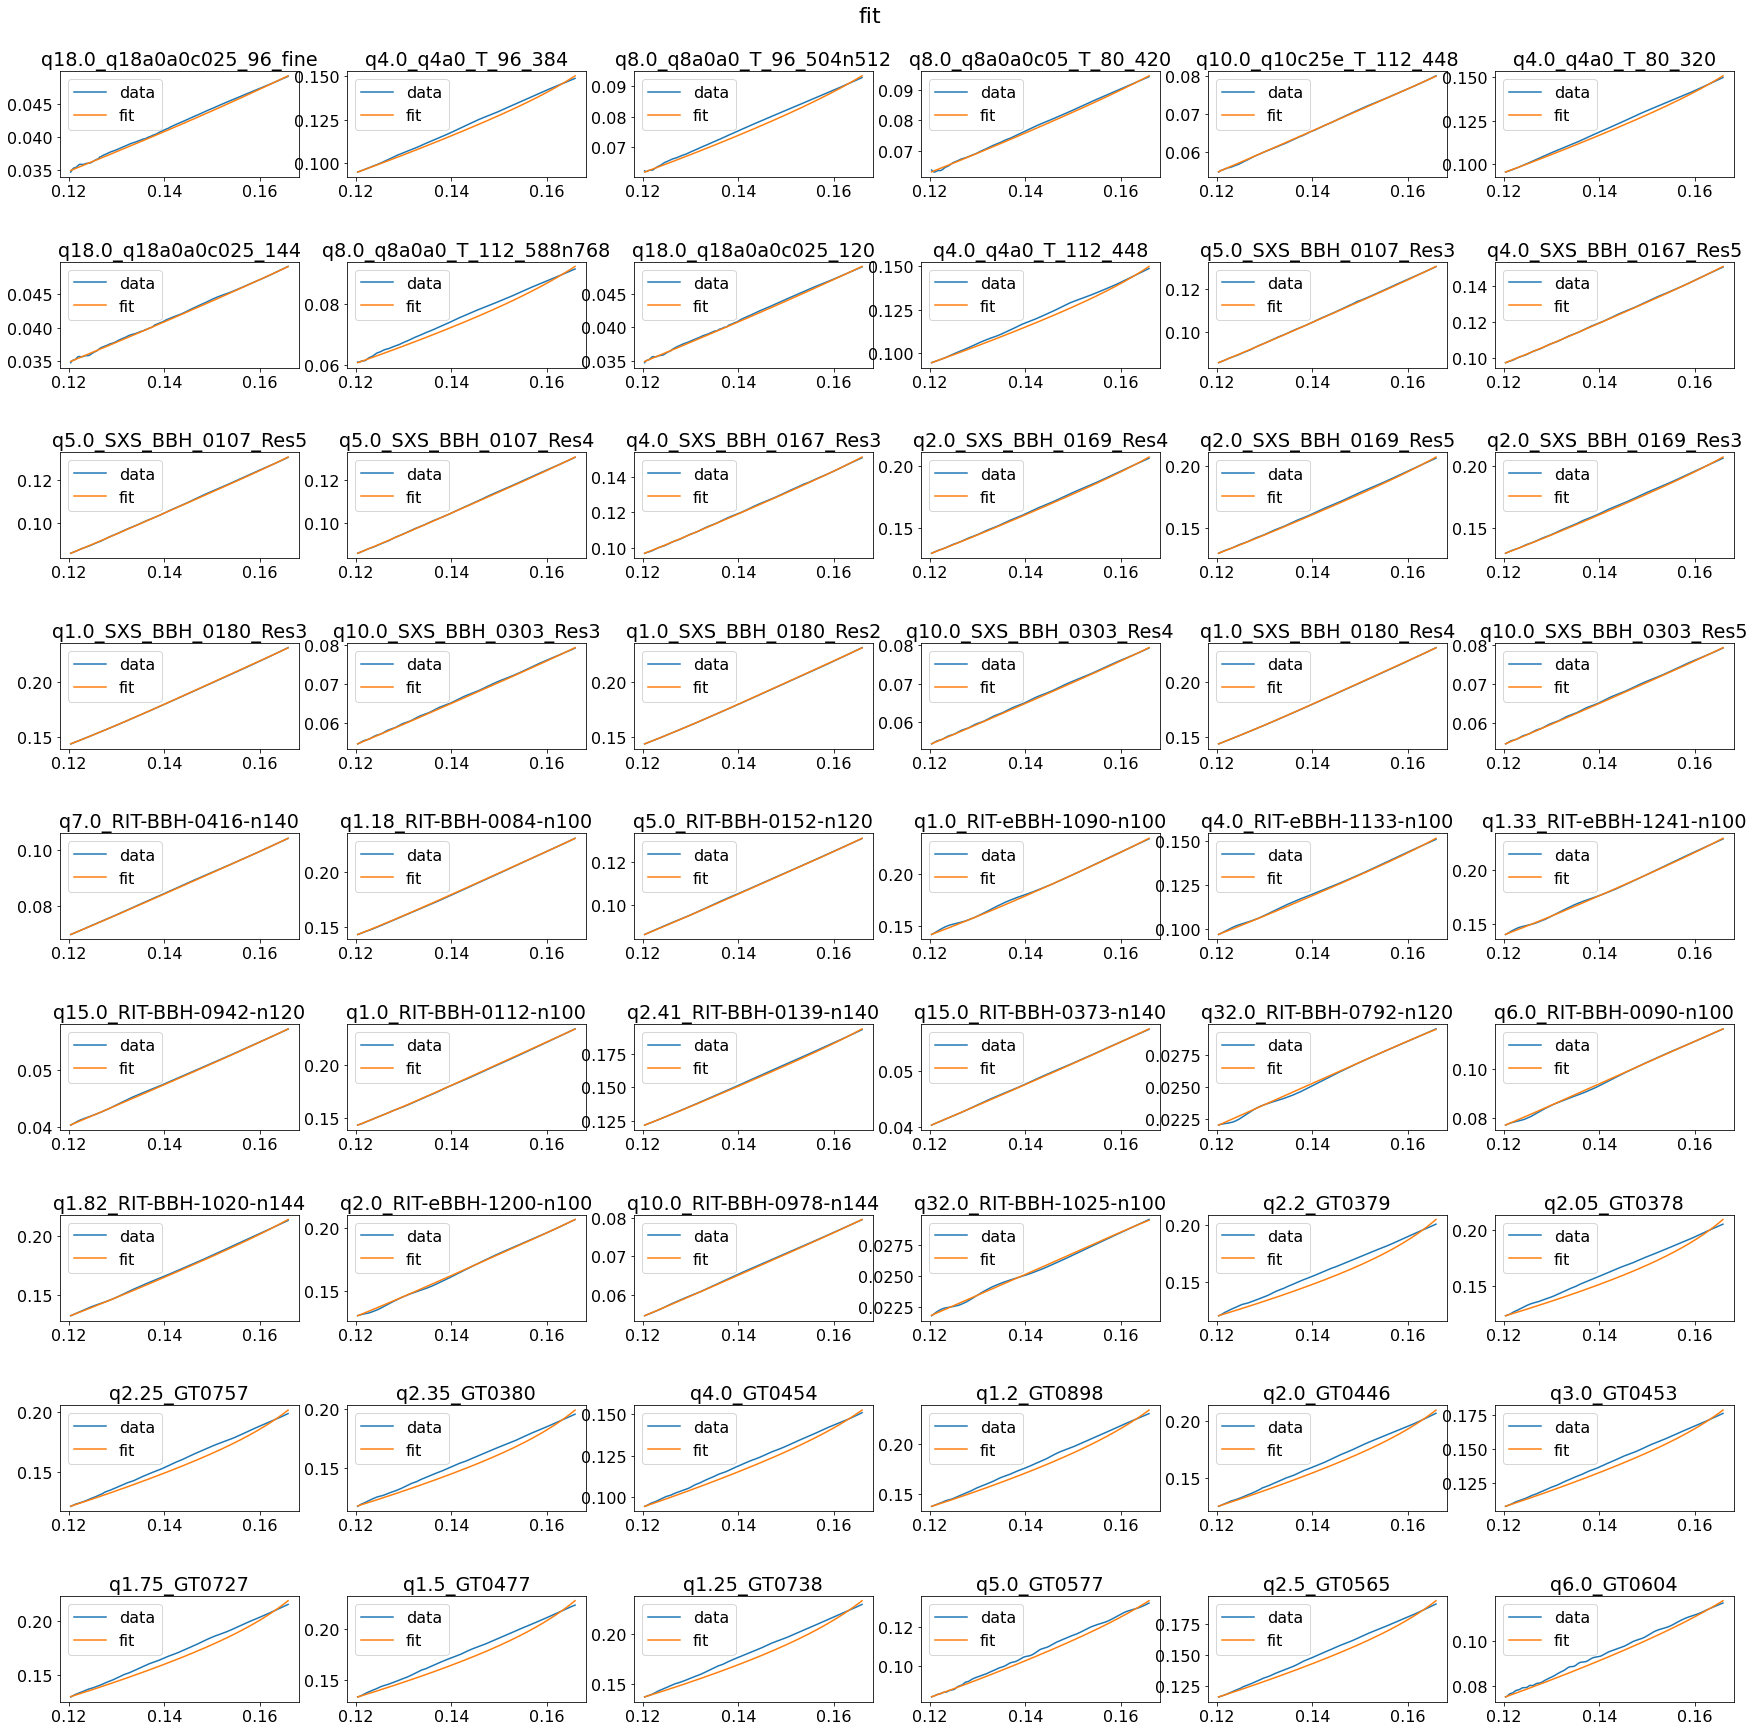

In [164]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_, y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data','fit'], suptitle="fit")

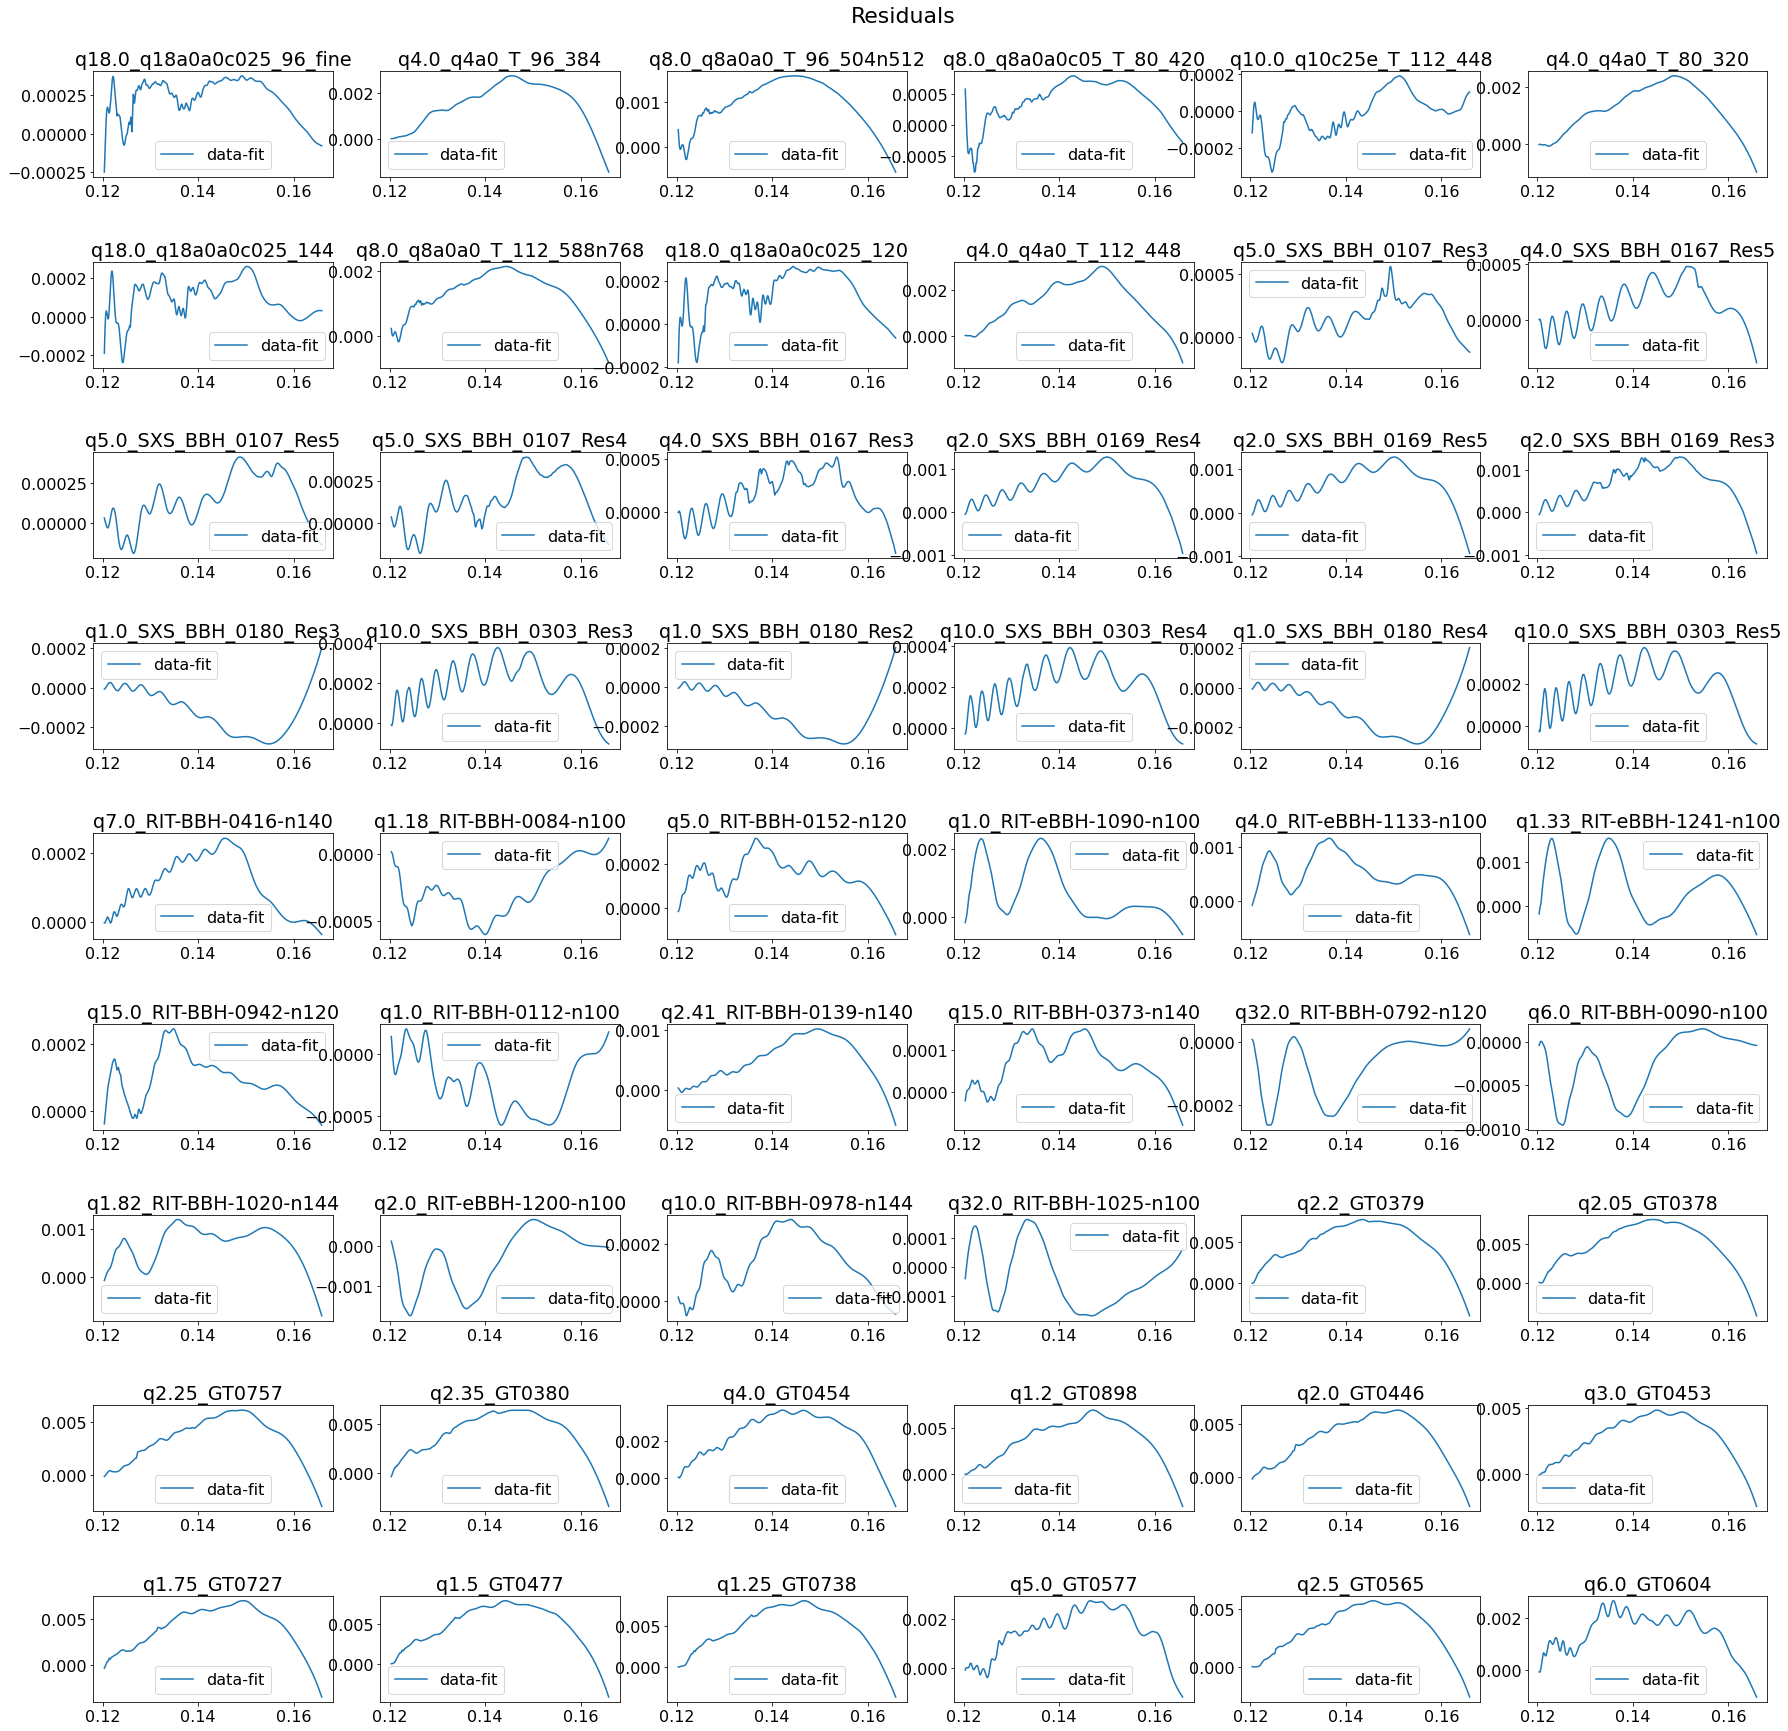

In [165]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_ - y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data-fit'], suptitle="Residuals")

# parameter space fits

## build train/test set for parameter space fits

In [166]:
# use these as the column names
# for the train/test set dataframes
# they correspond to the derivative-order
# and collocation point
tags = wcfs[0].cm.tags
tags

['d0_c0', 'd0_c1']

In [167]:
df_psf_x = data_dict['df']['q']

In [168]:
df_psf_y = pd.DataFrame(np.array([w.cm.rhs_1d for w in wcfs]), columns=tags)

In [169]:
df_psf_x_train = df_psf_x.iloc[data_dict['train_idxs']]
df_psf_y_train = df_psf_y.iloc[data_dict['train_idxs']]

In [170]:
df_psf_x_test = df_psf_x.iloc[data_dict['test_idxs']]
df_psf_y_test = df_psf_y.iloc[data_dict['test_idxs']]

In [171]:
df_psf_y

d0_c0     d0_c1
0  -0.008993 -0.013744
1  -0.023435 -0.028210
2  -0.032777 -0.033198
3  -0.013944 -0.018949
4   0.001981 -0.011044
5  -0.018764 -0.023083
6  -0.006717 -0.016706
7  -0.047003 -0.047254
8  -0.007655 -0.017332
9  -0.027691 -0.029885
10 -0.003744 -0.022152
11 -0.002822 -0.017315
12 -0.003737 -0.021596
13 -0.003675 -0.021695
14 -0.002903 -0.016732
15 -0.006748 -0.022427
16 -0.006716 -0.022412
17 -0.006701 -0.022325
18 -0.003994 -0.024755
19 -0.005971 -0.019499
20 -0.003912 -0.024692
21 -0.006307 -0.019344
22 -0.003981 -0.024716
23 -0.005969 -0.018858
24 -0.004180 -0.018514
25 -0.001297 -0.023918
26 -0.000665 -0.018016
27 -0.008482 -0.020346
28 -0.005345 -0.014765
29 -0.005952 -0.021428
30 -0.004638 -0.017164
31 -0.001571 -0.019845
32 -0.004179 -0.020997
33 -0.003384 -0.016060
34  0.007467  0.053616
35  0.000588 -0.019319
36 -0.006456 -0.021902
37  0.001344 -0.022992
38 -0.004162 -0.017025
39  0.001275  0.052042
40 -0.043212 -0.020278
41 -0.043204 -0.021102
42 -0.032472 -0.020805
43 -0.038109 -0.020018
44 -0.028592 -0.018062
45 -0.033634 -0.022688
46 -0.033662 -0.025427
47 -0.030394 -0.017624
48 -0.036072 -0.021476
49 -0.040562 -0.021776
50 -0.039443 -0.024984
51 -0.020605 -0.011401
52 -0.032452 -0.019935
53 -0.023751 -0.013304

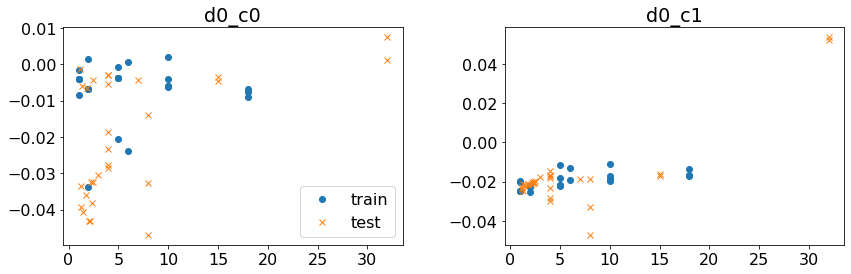

In [172]:
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, df_psf_y_train[col], 'o', label='train')
    ax.plot(df_psf_x_test, df_psf_y_test[col], 'x', label='test')
    ax.set_title(col)
    if i == 0:
        ax.legend()

In [173]:
alphas = workflow_utils.compute_alphas(df_psf_x_train, df_psf_y_train)

In [174]:
alphas_test = workflow_utils.compute_alphas(df_psf_x_test, df_psf_y_test)

In [175]:
alphas

{'d0_c0': array([0.00114391, 0.00349452, 0.00114391, 0.00114391, 0.00800335,
        0.00800335, 0.00800335, 0.01341276, 0.01341276, 0.01341276,
        0.00251223, 0.00349452, 0.00251223, 0.00349452, 0.00251223,
        0.00349452, 0.00800335, 0.00251223, 0.00251223, 0.01721031,
        0.01341276, 0.00349452, 0.01341276, 0.00800335, 0.01721031]),
 'd0_c1': array([0.00191643, 0.00355506, 0.00191643, 0.00191643, 0.0045454 ,
        0.0045454 , 0.0045454 , 0.00131828, 0.00131828, 0.00131828,
        0.00253976, 0.00355506, 0.00253976, 0.00355506, 0.00253976,
        0.00355506, 0.0045454 , 0.00253976, 0.00253976, 0.00425325,
        0.00131828, 0.00355506, 0.00131828, 0.0045454 , 0.00425325])}

In [176]:
# we need to store the sign of the data so that
# we can reverse a log(abs(x)) transformation
signs_dict = df_psf_y_train.apply(lambda x: np.sign(x)).iloc[[0]]
signs_dict

d0_c0  d0_c1
0   -1.0   -1.0

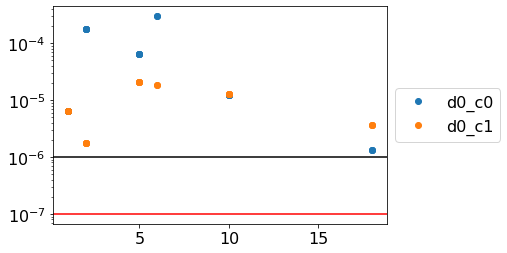

In [177]:
plt.figure()
for key in alphas.keys():
    plt.plot(df_psf_x_train, alphas[key]**2, 'o', label=key)
plt.axhline(1e-6, c='k')
plt.axhline(1e-7, c='r')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'test')

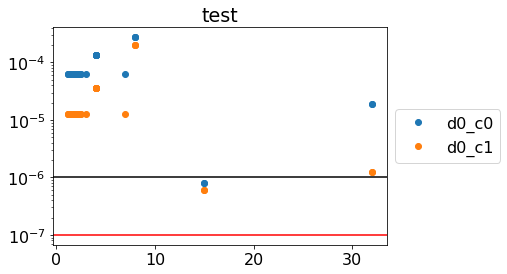

In [178]:
plt.figure()
for key in alphas_test.keys():
    plt.plot(df_psf_x_test, alphas_test[key]**2, 'o', label=key)
plt.axhline(1e-6, c='k')
plt.axhline(1e-7, c='r')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('test')

In [179]:
alpha_max = {}
safety_factor = 1
# safety_factor = 2
# safety_factor = 0.1
for k in alphas.keys():
    alpha_max[k] = alphas[k].max()**2 * safety_factor
    # alpha_max[k] = 1e-5/10
# alpha_max['d0_c0'] = 1e-7

In [180]:
alpha_max

{'d0_c0': 0.00029619472812261066, 'd0_c1': 2.0660705088193532e-05}

In [182]:
# loop over a fit
gps={}
for col in df_psf_y_train.columns:
    print(f"working: {col}")
    GaussianProcessRegressor_kwargs=dict(
        # kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct(sigma_0_bounds=(1e-5, 1e3)) * ConstantKernel(),
        # kernel=Matern(nu=2.5,  length_scale_bounds=(1e-3, 100000.0)) * ConstantKernel() + DotProduct(sigma_0_bounds=(1e-10, 1e4)) * ConstantKernel(),
        kernel=Matern(nu=2.5)*ConstantKernel() + WhiteKernel(noise_level=alpha_max[col], noise_level_bounds=(0.1*alpha_max[col], 1.01*alpha_max[col])),
        # kernel=Matern(nu=2.5)*ConstantKernel() + WhiteKernel(noise_level=custom_alpha[col], noise_level_bounds=(0.01*custom_alpha[col], 1.01*custom_alpha[col])),
        # kernel=Matern(nu=2.5) * ConstantKernel(),
        # kernel=RBF(length_scale_bounds=(1e-3, 1e8)),
        # kernel=Matern(nu=2.5)*ConstantKernel() + WhiteKernel(),
        # alpha=1e-5,
        # alpha=alphas[col],
        # alpha=alphas[col]/3,
        alpha=1e-10,
        random_state=0,
        # normalize_y=True,
        normalize_y=False,
        n_restarts_optimizer=100,
        # optimizer=None
    )
    
    # transformations
    # x -> log(x)
    # y -> log(sign(y) * y)
    # for y we first enforce that the target is positive and then we take the log
    # x=df_psf_x_train.apply(lambda x: np.log(x)).values
    # y=df_psf_y_train[col].apply(lambda x: np.log(np.abs(x))).values
    x=df_psf_x_train.values
    y=df_psf_y_train[col].values
    gp = workflow_utils.gpr_fit(
        x=x,
        y=y,
        GaussianProcessRegressor_kwargs=GaussianProcessRegressor_kwargs,
    )
    gps[col] = gp

working: d0_c0


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


working: d0_c1


In [183]:
gps['d0_c0'].kernel_

Matern(length_scale=1e+05, nu=2.5) * 0.00677**2 + WhiteKernel(noise_level=6.38e-05)

In [184]:
gps['d0_c1'].kernel_

Matern(length_scale=36.7, nu=2.5) * 0.0214**2 + WhiteKernel(noise_level=9.86e-06)

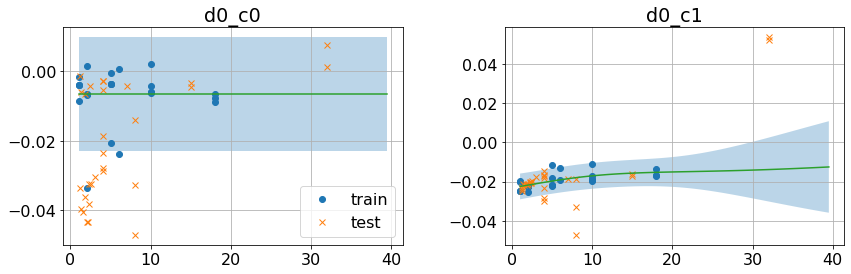

In [185]:
qs_fine = np.arange(1, 40, 0.5)[:,np.newaxis]
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    gp = gps[col]
    
    # generate samples and reverse transformation
    # mu_samples = gp.sample_y(np.log(qs_fine), n_samples=100, random_state=0)
    mu_samples = gp.sample_y(qs_fine, n_samples=100, random_state=0)
    # mu_samples = signs_dict[col].values * np.exp(mu_samples)
    # mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    # mu_test_lower = signs_dict[col].values * np.exp(mu_test-2*std_test)
    # mu_test_upper = signs_dict[col].values * np.exp(mu_test+2*std_test)
    # mu_test = signs_dict[col].values * np.exp(mu_test)
    
    mu_samples = mu_samples
    # mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    mu_test, std_test = gp.predict(qs_fine, return_std=True)
    mu_test_lower = mu_test-2*std_test
    mu_test_upper = mu_test+2*std_test
    mu_test = mu_test

    
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, df_psf_y_train[col], 'o', label='train')
    ax.plot(df_psf_x_test, df_psf_y_test[col], 'x', label='test')
    ax.plot(qs_fine, mu_test)
    # ax.plot(qs_fine, mu_samples, alpha=0.1, c='k')
    ax.fill_between(qs_fine[:,0], y1=mu_test_lower, y2=mu_test_upper, alpha=0.3)
    
    ax.set_title(col)
    if i == 0:
        ax.legend()
    # plt.axhline(1.5)
    # plt.axvline(32)
    # ax.set_ylim(0,3)
    ax.grid()
    
plt.show()
plt.close()

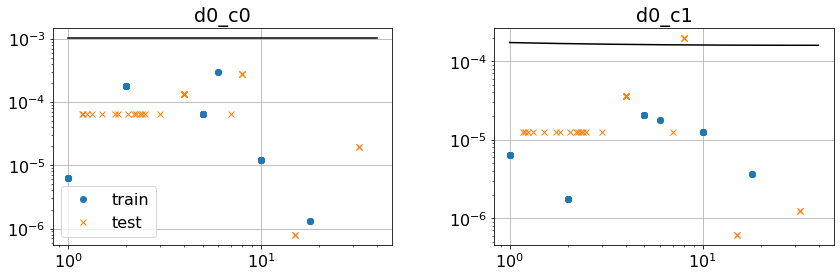

In [186]:
##### compare GPR variance with measured variance

qs_fine = np.arange(1, 40, 0.2)[:,np.newaxis]
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    gp = gps[col]
    
    # generate samples and reverse transformation
    mu_samples = gp.sample_y(np.log(qs_fine), n_samples=100, random_state=0)
    mu_samples = signs_dict[col].values * np.exp(mu_samples)
    mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    mu_test_lower = signs_dict[col].values * np.exp(mu_test-2*std_test)
    mu_test_upper = signs_dict[col].values * np.exp(mu_test+2*std_test)
    mu_test = signs_dict[col].values * np.exp(mu_test)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, alphas[col]**2, 'o', label='train')
    ax.plot(df_psf_x_test, alphas_test[col]**2, 'x', label='test')
    ax.plot(qs_fine, (mu_test_upper-mu_test_lower)**2, c='k')
    
    ax.set_title(col)
    if i == 0:
        ax.legend()
    # plt.axhline(1.5)
    # plt.axvline(32)
    # ax.set_ylim(0,3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    
plt.show()
plt.close()

#####

# model function

In [187]:
# generative phenomenological model (gpm)
def gpm_inspiral_amp_model(t, q, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=-1, random_state=None):
    """
    if n_samples = -1 then generate the mean otherwise draw a n_samples
    """
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
    if n_samples == -1:
        mode = "mean"
        n_samples = 1
    else:
        mode = "sample"
    
    t = np.atleast_1d(t)
    eta = phenom.eta_from_q(q)
    log_q = np.log(q)
    
    omega_22 = gpm_omega_inspiral.predict(t, q, n_samples=-1)[0]
    x_pn = pn.x_from_omega_22(omega_22, M=M)
    amp_N, amp_pn = workflow_utils.get_taylort3_inspiral_amp_affine_params(omega_22, eta, M)
    
    ansatz = base_ansatz.copy()
    
    # number of derivatives
    num_d_points = len(collocation_points.keys())
    # number of collocations points for each derivative
    num_c_points = [len(collocation_points[d]) for d in collocation_points.keys()]
    
    rhs = {}
    ## if mean then use the 'predict' method from the GP
    if mode == "mean":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].predict([[log_q]])
                # v = np.exp(v)
                # v = signs_dict[tag].values * v
                rhs[d].append(np.array([v]))
    ## if sample then use the 'sample_y' method from the GP
    elif mode == "sample":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].sample_y([[log_q]], n_samples, random_state=random_state)
                # v = np.exp(v)
                # v = signs_dict[tag].values * v
                rhs[d].append(v.T)
    else:
        raise ValueError(f"mode = {mode} unknown")

    # store a copy
    rhs_ = copy.deepcopy(rhs)
    
    collocation_points_x = workflow_utils.transform_collocation_t_to_x(collocation_points=collocation_points, q=q, gpm_omega_inspiral=gpm_omega_inspiral)
    
    yhats = []
    for n in range(n_samples):
        
        # have to extract the rhs for each sample
        for d in rhs_.keys():
            for i in range(len(rhs_[d])):
                rhs[d][i] = rhs_[d][i][n,0]
                
        
        cm = collocation.CollocationModel(
            collocation_points=collocation_points_x,
            rhs=rhs,
            ansatz=ansatz,
            sub_dict=None,
        )
        yhat = cm.predict(x_pn)
        yhat = workflow_utils.transformation_affine_foward(yhat, amp_N, amp_pn)
        yhats.append(yhat)
    
    return np.array(yhats)

In [188]:
t_star = np.arange(-700, -200, 1)
q_star = 1

In [189]:
yhats = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=-1)

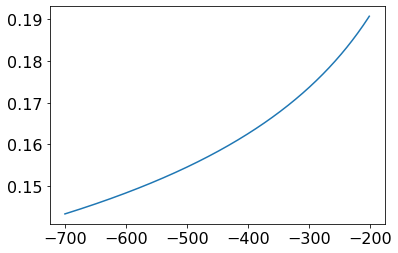

In [190]:
plt.plot(t_star, yhats[0])

# model validation

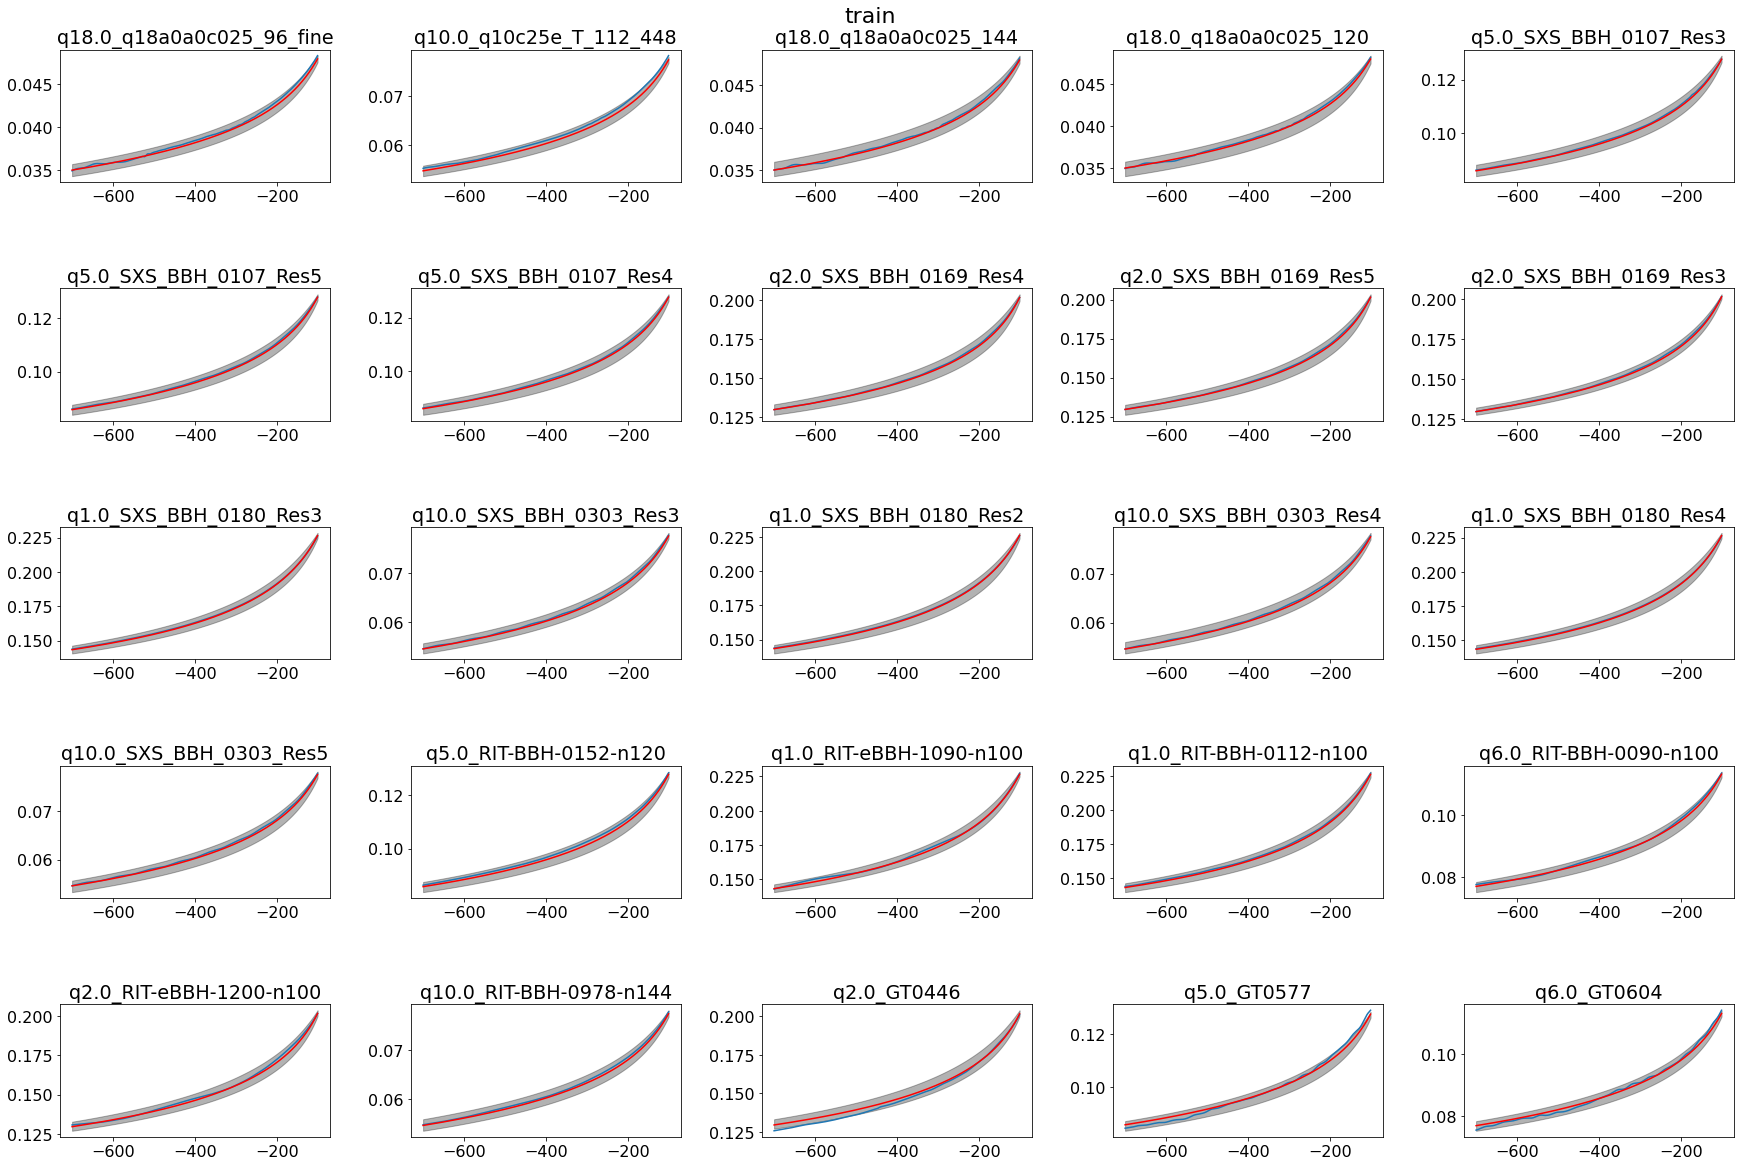

In [191]:
ncols = 5
samples = data_dict['train_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("train", fontsize=22, y=0.91)
    
for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['amps'][idx]
    ynr = ynr[mask]
    
    
    yhats = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=-1)
    yhats_samples = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    # ax.plot(t_star, ynr-yhats[0], c='r')
    # ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    
    ax.plot(t_star, ynr)
    ax.plot(t_star, yhats[0], c='r')
    ax.fill_between(t_star, y1=yhats_samples.min(0), y2=yhats_samples.max(0), color='k', alpha=0.3)
    
    # ax.axhline(0, c='C0')
    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)

plt.show()
plt.close()

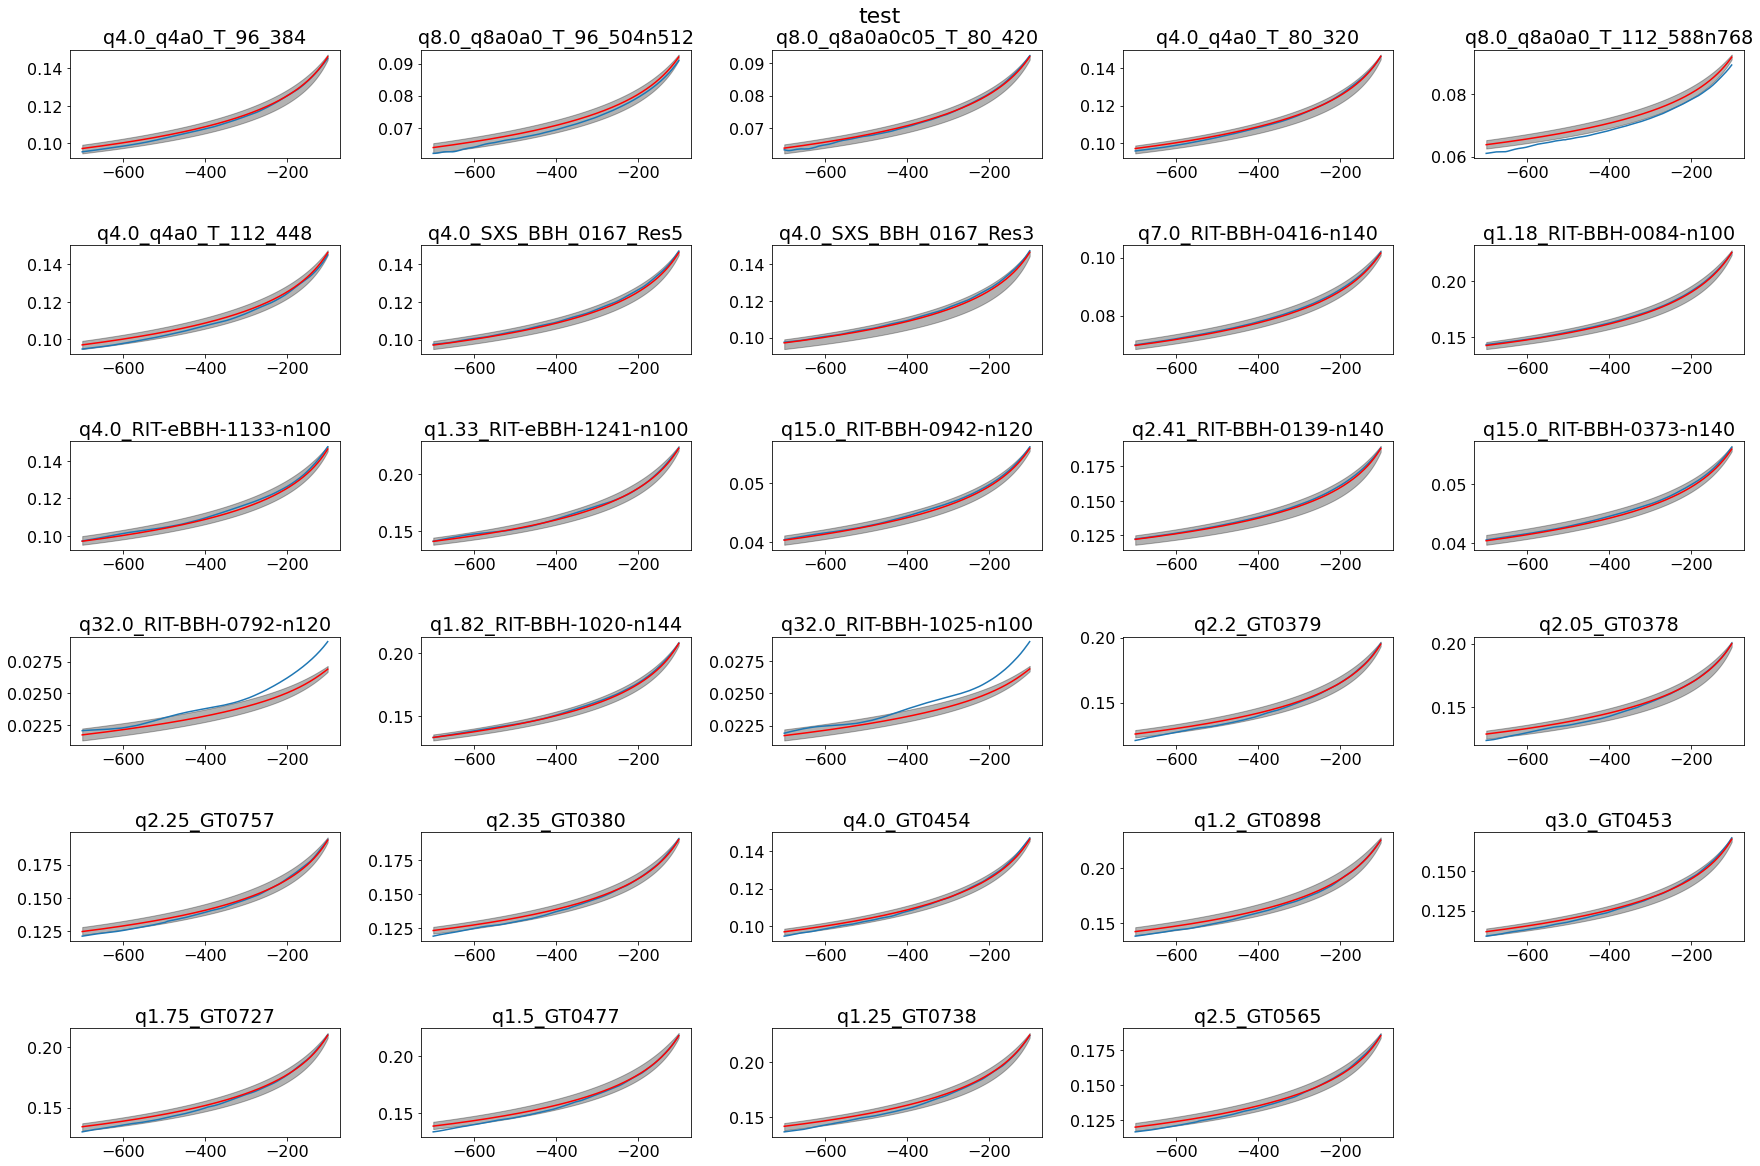

In [192]:
ncols = 5
samples = data_dict['test_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("test", fontsize=22, y=0.91)

for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['amps'][idx]
    ynr = ynr[mask]
    yhats = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=-1)
    yhats_samples = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    # ax.plot(t_star, ynr-yhats[0], c='r')
    # ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    
    ax.plot(t_star, ynr)
    ax.plot(t_star, yhats[0], c='r')
    ax.fill_between(t_star, y1=yhats_samples.min(0), y2=yhats_samples.max(0), color='k', alpha=0.3)
    
    # ax.axhline(0, c='C0')
    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)
plt.show()
plt.close()

# save model

In [193]:
components_to_save = {
    "collocation_points":collocation_points,
    "base_ansatz":base_ansatz,
    "gps":gps,
}

In [194]:
output_filename = os.path.join(OUTPUT_PATH, 'components.cpkl')

In [195]:
output_filename

'/Users/sebastian.khan/personal/data/gpm_model/amp_inspiral_11_09_23/components.cpkl'

In [196]:
with open(output_filename, "wb") as f:
    cloudpickle.dump(components_to_save, f)

In [197]:
# with open(output_filename, 'rb') as f:
#     test_c = cloudpickle.load(f)

In [198]:
# test_c.keys()

In [199]:
# collocation_points = test_c["collocation_points"]
# base_ansatz = test_c["base_ansatz"]
# gps = test_c["gps"]

In [200]:
data_dict['df'].query('q==10')

name     q     fring     fdamp  duration  t_final  \
4   q10c25e_T_112_448  10.0  0.066184  0.014119    1157.7    121.6   
19  SXS_BBH_0303_Res3  10.0  0.066184  0.014119    3397.6    498.9   
21  SXS_BBH_0303_Res4  10.0  0.066184  0.014119    3433.2    499.1   
23  SXS_BBH_0303_Res5  10.0  0.066184  0.014119    3461.4    499.7   
38  RIT-BBH-0978-n144  10.0  0.066184  0.014119    1963.0    393.4   

    start_freq_100Msun    set  has_dup                      tag  
4            24.089458  train     True  q10.0_q10c25e_T_112_448  
19           24.051628  train     True  q10.0_SXS_BBH_0303_Res3  
21           23.964726  train     True  q10.0_SXS_BBH_0303_Res4  
23           23.954080  train     True  q10.0_SXS_BBH_0303_Res5  
38           23.965060  train     True  q10.0_RIT-BBH-0978-n144

In [201]:
# t_star = np.arange(-700, -300, 1)
t_star = np.arange(-700, -100, 1)
# t_star = np.arange(-2000, -100, 1)
# t_star = np.arange(-900, -200, 1)
# q_star = 32

# idx = 34
# idx = 8
# idx = 22
# idx = 7
# idx = 33
idx = 28
# idx = 19
q_star = data_dict['df']['q'][idx]

In [202]:
q_star

4.0

In [203]:
yhats = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=-1)

In [204]:
yhats_samples = gpm_inspiral_amp_model(t_star, q_star, M, collocation_points, base_ansatz, gps, gpm_omega_inspiral, n_samples=100)

In [205]:
yhats.shape

(1, 600)

In [206]:
data_dict['df'].iloc[idx]['q']

4.0

In [207]:
t_start

-710

In [208]:
collocation_points

{0: [-700, -100]}

In [209]:
amp_pn = np.abs(pn.TaylorT3_Hhat22(t_star, gpm_omega_inspiral.tc, phenom.eta_from_q(q_star), M))

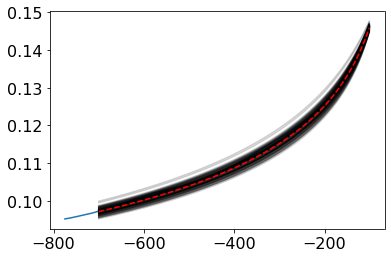

In [210]:
mask = waveforms[idx].times < t_star[-1]
plt.plot(waveforms[idx].times[mask], waveforms[idx].amp[mask], label='data')

plt.plot(t_star, yhats_samples.T, c='k', alpha=0.2);
plt.plot(t_star, yhats[0], c='r', ls='--')

# plt.plot(t_star, amp_pn)


# plt.yscale('log')
# plt.xlim(-800, -100)
# plt.ylim(0.05, 0.3)